In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Variants/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


In [3]:
learning_rates_list = [1e-3, 1e-4, 1e-5]
patiences_list = [20, 50]
num_layers_list = [1, 2, 4, 8]
batch_sizes_list = [32, 64]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout]
                        i += 1
                        
print(i)

144


In [4]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', 'alpha_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

rmse_min = np.inf
best_model = {}

for hyperparameter in tqdm(hyperparameter_dict.values(), desc = '대구_GRU', position = 0):
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    print('-------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 59, 60, 1, batch_size, 'mto')
    

    model = GRU(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers, 
                dropout = dropout, 
                device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_One(train_loader, 
                                                  test_loader, 
                                                  model, 
                                                  criterion, 
                                                  optimizer, 
                                                  num_epochs, 
                                                  patience,
                                                  device)
    
    label_y, predicted = predict_mto(model, df, x_ss, y_ms)
    
    if rmse_min > rmse(label_y[-7:], predicted[-7:]):
        rmse_min = rmse(label_y[-7:], predicted[-7:])
        best_model['GRU'] = [rmse_min, model, loss_list, epoch, lr, patience, 
                             num_layers, batch_size, hidden_size, dropout]

대구_GRU:   0%|          | 0/144 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 105 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 229 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 116 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 620 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 694 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 455 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 106 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 117 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 171 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 155 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 175 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 152 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 144 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 166 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 132 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 211 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 244 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 31 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 95 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 81 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 49 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 208 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 412 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 387 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 652 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 963 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1014 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 264 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 390 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 197 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 182 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 258 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 493 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 402 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 611 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 819 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 448 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 568 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 790 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 444 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 438 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 325 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 337 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 85 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 591 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 361 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 724 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 561 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 175 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1395 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1339 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 158 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 144 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 261 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 203 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 139 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 89 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 273 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 242 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 118 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 142 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 48 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 167 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 251 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 48 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 64 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 59 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 28 loss: 0.0019
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 46 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 86 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 375 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 346 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1054 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1526 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 912 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 640 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 168 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 476 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 328 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 274 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 379 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 391 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 354 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 333 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 809 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 62 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 112 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 950 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 129 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 393 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 530 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 227 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 67 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 584 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3975 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2816 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2211 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 8781 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4148 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3568 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 229 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 294 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 487 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 152 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 84 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 132 loss: 0.0016
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 126 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 54 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 36 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 153 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 83 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 70 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 35 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 30 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 26 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 50 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 136 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4151 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2997 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3683 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 7091 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 6710 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4757 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 199 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 680 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 490 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 599 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 857 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 886 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 120 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 159 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 656 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 370 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 107 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 104 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 94 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 147 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 132 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 128 loss: 0.0019
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 133 loss: 0.0018


In [5]:
best_model

{'GRU': [0.06689627846990784,
  GRU(
    (gru): GRU(3, 8, batch_first=True, dropout=0.25)
    (fc1): Linear(in_features=480, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU()
  ),
  [0.04441740736365318,
   0.04398244991898537,
   0.043550044298172,
   0.043119415640830994,
   0.042690470814704895,
   0.0422632172703743,
   0.041838157922029495,
   0.04141448810696602,
   0.0409921370446682,
   0.040571581572294235,
   0.04015425220131874,
   0.0397396981716156,
   0.03932870924472809,
   0.03892024978995323,
   0.03851402550935745,
   0.03811106085777283,
   0.03771067410707474,
   0.03731318563222885,
   0.03691926598548889,
   0.03652804344892502,
   0.036138519644737244,
   0.03575179725885391,
   0.035367753356695175,
   0.03498615697026253,
   0.03460780903697014,
   0.03423169627785683,
   0.03385740891098976,
   0.03348585218191147,
   0.03311799839138985,
 

In [6]:
save_model(best_model['GRU'][1].state_dict(), "model/Infected/alpha/GRU.pth")
save_hyperparameter(best_model['GRU'][3:], "hyperparameter/Infected/alpha/GRU.pkl")

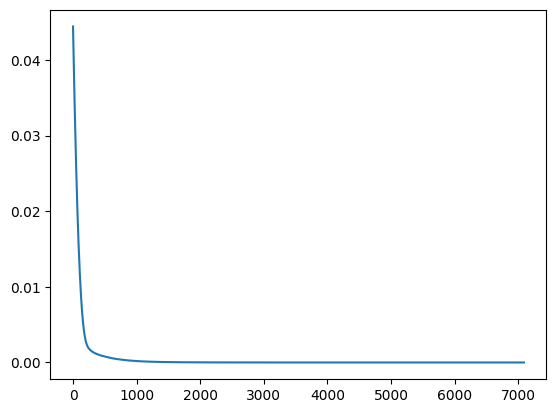

In [7]:
plt.plot(best_model['GRU'][2])

In [8]:
label_y, predicted = predict_mto(best_model['GRU'][1], df, x_ss, y_ms)

0.2022753238967935


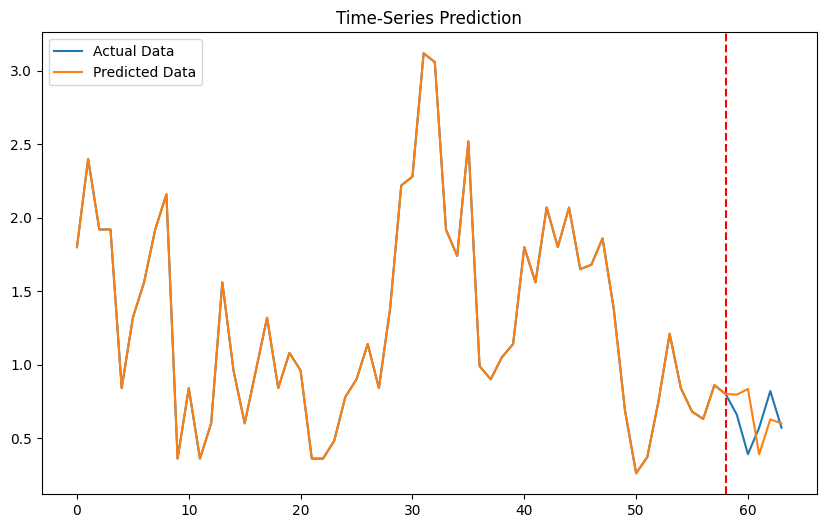

In [13]:
print(rmse(label_y[-7:], predicted[-7:]))
plotting(label_y, predicted, 58)

In [12]:
rmse(label_y[-7:], predicted[-7:])

0.2022753238967935